# Neural Networks Part 3:

## Pre-Trained Networks and Word Embeddings and LSTMs, oh my!

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# Defining our results visualization function
def visualize_training_results(history):
    '''
    From https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    
    Input: keras history object (output from trained model)
    '''
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    fig.suptitle('Model Results')

    # summarize history for accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_ylabel('Accuracy')
    ax1.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_ylabel('Loss')
    ax2.legend(['train', 'test'], loc='upper left')
    
    plt.xlabel('Epoch')
    plt.show()

## First: Pre-Trained Image Classification Model

A pretrained network (also known as a convolutional base for CNNs) consists of layers that have already been trained on typically general data. For images, these layers have already learned general patterns, textures, colors, etc. such that when you feed in your training data, certain features can immediately be detected. This part is **feature extraction**.

You typically add your own final layers to train the network to classify/regress based on your problem. This component is **fine tuning**

Here are the pretrained image classification models that exist within Keras: https://keras.io/api/applications/

To demonstrate the utility of pretrained networks, we'll compare model performance between a baseline model and a model using a pretrained network (VGG19).

### Adding Pretrained Layers

VGG19: https://keras.io/api/applications/vgg/#vgg19-function

In [3]:
from keras.applications import VGG19

In [4]:
pretrained = VGG19(weights='imagenet',
                   include_top=True,
                   input_shape=(224, 224, 3))
# May download data at this step, shouldn't take long

In [5]:
pretrained.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
cnn = keras.models.Sequential()
cnn.add(pretrained)

# freezing layers so they don't get retrained with your new data
for layer in cnn.layers:
    layer.trainable=False 

In [7]:
# adding our own dense layers
cnn.add(layers.Flatten())
cnn.add(layers.Dense(132, activation='relu'))
cnn.add(layers.Dense(1, activation='softmax'))

In [8]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1000)              143667240 
_________________________________________________________________
flatten (Flatten)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 132)               132132    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 133       
Total params: 143,799,505
Trainable params: 132,265
Non-trainable params: 143,667,240
_________________________________________________________________


In [9]:
# to verify that the weights are "frozen" 
for layer in cnn.layers:
    print(layer.name, layer.trainable)

vgg19 False
flatten True
dense True
dense_1 True


With this you can now compile and fit your model!

## Now: Using Pre-Trained Embeddings and NNs for NLP Tasks

For the most part, following this example: https://stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/

Also relevant: https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/

Data is: https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [10]:
# Read in and explore the data
df = pd.read_csv('data/IMDB_Reviews.csv')

In [11]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


### Pre-Split Preprocessing

Doing some initial preprocessing that can be done before the train/test split

In [13]:
# Let's check out an example review...
df['review'][1]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

We have some HTML tags inside these texts... will want to remove them. But how?

Enter: Regular Expressions (regex).

Testing: https://regexr.com/

In [15]:
# Find the pattern to remove html tags
import re

html_tag_pattern = re.compile(r'<[^>]*>')

test = html_tag_pattern.sub('', df['review'][1])

In [16]:
test

'A wonderful little production. The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well done.'

In [19]:
# Apply our pattern to the dataset
df['review'] = df['review'].apply(lambda x:  html_tag_pattern.sub('', x))

# Same as:
# df['review'].apply(lambda x:  re.sub(r'<[^>]*>', '', x))

In [21]:
# Sanity check
df['review'][1]

'A wonderful little production. The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well done.'

Let's also remove stopwords

In [22]:
# Define our stopwords list
stop_words = stopwords.words('english')

In [27]:
# Remove them
df['review'] = df['review'].apply(lambda x: ' '.join(
    [word for word in x.split() if word.lower() not in (stop_words)]))

In [28]:
df['review'][1]

'wonderful little production. filming technique unassuming- old-time-BBC fashion gives comforting, sometimes discomforting, sense realism entire piece. actors extremely well chosen- Michael Sheen "has got polari" voices pat too! truly see seamless editing guided references Williams\' diary entries, well worth watching terrificly written performed piece. masterful production one great master\'s comedy life. realism really comes home little things: fantasy guard which, rather use traditional \'dream\' techniques remains solid disappears. plays knowledge senses, particularly scenes concerning Orton Halliwell sets (particularly flat Halliwell\'s murals decorating every surface) terribly well done.'

Can also pre-process our target variable

In [29]:
# Create a target map
target_map = {'positive': 1,
              'negative': 0}

In [32]:
# Map it
df['sentiment'] = df['sentiment'].map(target_map)

In [33]:
# Sanity check
df.head()

,review,sentiment
0,One reviewers mentioned watching 1 Oz episode ...,1
1,wonderful little production. filming technique...,1
2,thought wonderful way spend time hot summer we...,1
3,Basically there's family little boy (Jake) thi...,0
4,"Petter Mattei's ""Love Time Money"" visually stu...",1


### Split, and then Post-Split Processing
Now let's perform a train/test split:

In [34]:
# Define our X and y
X = df['review']
y = df['sentiment']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [35]:
X_train.shape

(37500,)

Now, time to tokenize our text. Going to use keras's tokenizer: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

In [36]:
# Showcasing an example to start
X_train[2]

'thought wonderful way spend time hot summer weekend, sitting air conditioned theater watching light-hearted comedy. plot simplistic, dialogue witty characters likable (even well bread suspected serial killer). may disappointed realize Match Point 2: Risk Addiction, thought proof Woody Allen still fully control style many us grown love.This I\'d laughed one Woody\'s comedies years (dare say decade?). I\'ve never impressed Scarlet Johanson, managed tone "sexy" image jumped right average, spirited young woman.This may crown jewel career, wittier "Devil Wears Prada" interesting "Superman" great comedy go see friends.'

In [37]:
# Find our longest review - will need for padding later
max_length = max([len(s.split()) for s in X_train])
max_length

1452

In [39]:
len(df['review'][1].split())

87

In [40]:
# Now to tokenize
# Recommend checking out their default values - they're removing punctuation for us!
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [41]:
# Same example, after processing
print(X_train[2])

[131, 152, 1, 105, 45, 30, 1510, 1038, 3560, 14062, 138, 79, 86, 44, 56, 57, 2562, 889, 200, 57, 252, 18030, 280, 7545, 483, 21, 635, 136, 2435, 8862, 5281, 146, 63, 376, 172, 27, 537, 23, 16, 2, 162, 502, 269, 12057, 677, 105, 93, 5, 199, 725, 1, 876, 903, 18031, 59, 14063, 1871, 3, 1543, 6, 1128, 4988, 427, 2582, 132, 204, 7956, 2052]


In [42]:
tokenizer.word_index

{'movie': 1,
 'film': 2,
 'one': 3,
 'like': 4,
 'good': 5,
 'it': 6,
 'the': 7,
 'time': 8,
 'even': 9,
 'would': 10,
 'really': 11,
 'story': 12,
 'see': 13,
 'well': 14,
 'much': 15,
 'bad': 16,
 'get': 17,
 'great': 18,
 'also': 19,
 'people': 20,
 'first': 21,
 'made': 22,
 'make': 23,
 'way': 24,
 'could': 25,
 'movies': 26,
 'think': 27,
 'characters': 28,
 'watch': 29,
 'seen': 30,
 'films': 31,
 'two': 32,
 'many': 33,
 'character': 34,
 'plot': 35,
 'never': 36,
 'acting': 37,
 'love': 38,
 'life': 39,
 'best': 40,
 'know': 41,
 'little': 42,
 'show': 43,
 'i': 44,
 'ever': 45,
 'this': 46,
 'better': 47,
 'end': 48,
 'scene': 49,
 'man': 50,
 'still': 51,
 'say': 52,
 'scenes': 53,
 'and': 54,
 'something': 55,
 'go': 56,
 'back': 57,
 'real': 58,
 "i'm": 59,
 'watching': 60,
 'thing': 61,
 'though': 62,
 'actors': 63,
 'years': 64,
 'funny': 65,
 'actually': 66,
 'old': 67,
 '10': 68,
 'another': 69,
 'work': 70,
 'makes': 71,
 'nothing': 72,
 'look': 73,
 'going': 74,
 'fi

In [43]:
# Grab the corpus size
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

110202


In [44]:
# Now, let's pad so each review is the same length as our longest review
# Basically, adding zeros at the end

X_train = keras.preprocessing.sequence.pad_sequences(
    X_train, maxlen=max_length, padding='post')
X_test = keras.preprocessing.sequence.pad_sequences(
    X_test, maxlen=max_length, padding='post')

In [45]:
X_train[2]

array([131, 152,   1, ...,   0,   0,   0], dtype=int32)

### Pre-Trained Word Embeddings: GloVe (Global Vectors for Word Representation)

The link to download the GloVe files: https://nlp.stanford.edu/projects/glove/

The below function and code comes from: https://realpython.com/python-keras-text-classification/#using-pretrained-word-embeddings

In [47]:
def create_embedding_matrix(glove_filepath, word_index, embedding_dim):
    '''
    Grabs the embeddings just for the words in our vocabulary
    
    Inputs:
    glove_filepath - string, location of the glove text file to use
    word_index - word_index attribute from the keras tokenizer
    embedding_dim - int, number of dimensions to embed, a hyperparameter
    
    Output:
    embedding_matrix - numpy array of embeddings
    '''
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(glove_filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [48]:
embedding_dim = 50
embedding_matrix = create_embedding_matrix('glove.6B.50d.txt',
                                           tokenizer.word_index, 
                                           embedding_dim)

In [49]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.30824   ,  0.17223001, -0.23339   , ..., -0.98176998,
        -0.32146999,  0.99822998],
       [ 0.06912   ,  0.22159   , -0.66613001, ..., -0.93550998,
        -0.20942999,  0.67333001],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.11450005, -0.36491001,  0.27649   , ..., -0.29796001,
         0.60066998, -0.73312002],
       [ 0.039808  ,  0.70003003,  0.85829997, ..., -1.84660006,
        -0.53987998,  0.30724001]])

In [50]:
# Time to model!
model = keras.models.Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=max_length, 
                           trainable=False)) # Note - not retraining the embedding layer
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1452, 50)          5510100   
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 5,510,621
Trainable params: 521
Non-trainable params: 5,510,100
_________________________________________________________________


In [51]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=100,
                    validation_data=(X_test, y_test))

Epoch 1/10
375/375 [==============================] - 4s 10ms/step - loss: 0.6943 - accuracy: 0.5274 - val_loss: 0.6703 - val_accuracy: 0.5922
Epoch 2/10
375/375 [==============================] - 4s 10ms/step - loss: 0.6588 - accuracy: 0.6071 - val_loss: 0.6442 - val_accuracy: 0.6321
Epoch 3/10
375/375 [==============================] - 4s 10ms/step - loss: 0.6387 - accuracy: 0.6380 - val_loss: 0.6294 - val_accuracy: 0.6518
Epoch 4/10
375/375 [==============================] - 4s 10ms/step - loss: 0.6307 - accuracy: 0.6448 - val_loss: 0.6230 - val_accuracy: 0.6576
Epoch 5/10
375/375 [==============================] - 4s 10ms/step - loss: 0.6248 - accuracy: 0.6514 - val_loss: 0.6182 - val_accuracy: 0.6608
Epoch 6/10
375/375 [==============================] - 4s 11ms/step - loss: 0.6193 - accuracy: 0.6583 - val_loss: 0.6139 - val_accuracy: 0.6656
Epoch 7/10
375/375 [==============================] - 4s 10ms/step - loss: 0.6171 - accuracy: 0.6591 - val_loss: 0.6135 - val_accuracy: 0.6632

Test loss: 0.610451340675354
Test accuracy: 0.6627200245857239


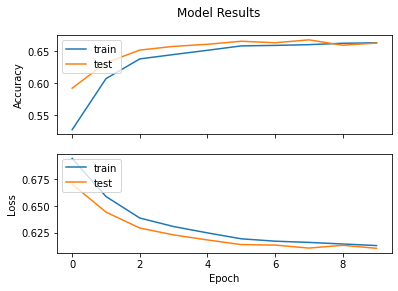

In [52]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

# Visualize results
visualize_training_results(history)

Evaluate:

- 


### Treat Embeddings as Starting Weights, but Allow Training:

In [53]:
# Time to model!
model = keras.models.Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=max_length, 
                           trainable=True)) # Now it can retrain the embedding layer
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1452, 50)          5510100   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 5,510,621
Trainable params: 5,510,621
Non-trainable params: 0
_________________________________________________________________


In [54]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=100,
                    validation_data=(X_test, y_test))
# Takes about... 3 minutes?

Epoch 1/10
375/375 [==============================] - 35s 92ms/step - loss: 0.6522 - accuracy: 0.6203 - val_loss: 0.5886 - val_accuracy: 0.7138
Epoch 2/10
375/375 [==============================] - 36s 97ms/step - loss: 0.5082 - accuracy: 0.7675 - val_loss: 0.4582 - val_accuracy: 0.7905
Epoch 3/10
375/375 [==============================] - 36s 96ms/step - loss: 0.3973 - accuracy: 0.8263 - val_loss: 0.4037 - val_accuracy: 0.8162
Epoch 4/10
375/375 [==============================] - 34s 92ms/step - loss: 0.3337 - accuracy: 0.8577 - val_loss: 0.3724 - val_accuracy: 0.8337
Epoch 5/10
375/375 [==============================] - 35s 93ms/step - loss: 0.2843 - accuracy: 0.8827 - val_loss: 0.3610 - val_accuracy: 0.8400
Epoch 6/10
375/375 [==============================] - 34s 90ms/step - loss: 0.2452 - accuracy: 0.9024 - val_loss: 0.3568 - val_accuracy: 0.8458
Epoch 7/10
375/375 [==============================] - 36s 95ms/step - loss: 0.2101 - accuracy: 0.9179 - val_loss: 0.3579 - val_accuracy:

Test loss: 0.3918270766735077
Test accuracy: 0.8504800200462341


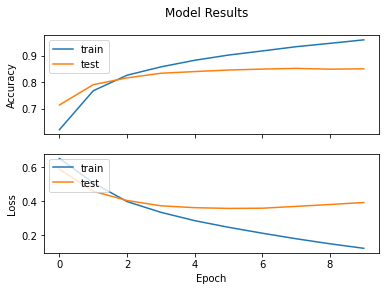

In [55]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

# Visualize results
visualize_training_results(history)

Evalutate:

- 


### Early Stopping

Patience: how many epochs that model can keep running without improvement before the training is stopped

Reference: https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

In [56]:
# Implement early stopping
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [57]:
# Combine with a model saving feature, so it saves as it improves
from keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [58]:
# Same model as just before this
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1452, 50)          5510100   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 5,510,621
Trainable params: 5,510,621
Non-trainable params: 0
_________________________________________________________________


In [59]:
# Just adding more epochs
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=100,
                    validation_data=(X_test, y_test),
                    callbacks=[es, mc])

Epoch 1/100
375/375 [==============================] - ETA: 0s - loss: 0.0971 - accuracy: 0.9702
Epoch 00001: val_accuracy improved from -inf to 0.85064, saving model to best_model.h5
375/375 [==============================] - 35s 94ms/step - loss: 0.0971 - accuracy: 0.9702 - val_loss: 0.4116 - val_accuracy: 0.8506
Epoch 2/100
375/375 [==============================] - ETA: 0s - loss: 0.0763 - accuracy: 0.9788
Epoch 00002: val_accuracy did not improve from 0.85064
375/375 [==============================] - 37s 100ms/step - loss: 0.0763 - accuracy: 0.9788 - val_loss: 0.4346 - val_accuracy: 0.8478
Epoch 3/100
375/375 [==============================] - ETA: 0s - loss: 0.0595 - accuracy: 0.9848
Epoch 00003: val_accuracy did not improve from 0.85064
375/375 [==============================] - 35s 94ms/step - loss: 0.0595 - accuracy: 0.9848 - val_loss: 0.4575 - val_accuracy: 0.8480
Epoch 00003: early stopping


### LSTM - Long Short Term Memory

Note: current bug in tensorflow related to the newest numpy version, if you have numpy version 1.20 + this won't work.

https://github.com/tensorflow/models/issues/9706

In [60]:
np.__version__

'1.20.1'

In [ ]:
model = keras.models.Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim,
                           weights=[embedding_matrix],
                           input_length=max_length,
                           trainable=True))
# Changing our previous simple dense layer to an LSTM
# Adding some dropout to prevent overfitting
model.add(layers.LSTM(embedding_dim, 
                      dropout=0.2,
                      return_sequences=True))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=100,
                    validation_data=(X_test, y_test))

Post-class note: I will add a version of the Kaggle notebook or a link to the Kaggle notebook with the output so you can see what this looks like after it's run!

### Saving your model

In [61]:
model.save('model.h5')
model.save_weights('model_weights.h5')

In [65]:
from keras.models import load_model

my_model = load_model('best_model.h5')
# my_model.load_weights('model_weights.h5')

In [67]:
my_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1452, 50)          5510100   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 5,510,621
Trainable params: 5,510,621
Non-trainable params: 0
_________________________________________________________________


In [66]:
my_model.evaluate(X_test, y_test)

391/391 [==============================] - 1s 2ms/step - loss: 0.4116 - accuracy: 0.8506


[0.41158032417297363, 0.8506399989128113]